# Training Set Analysis
The purpose of this notebook is to compute the kernel density estimate of the PDF between the judgement and each feature in a training set, in order to estimate how each feature is performing.

In [177]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pylab as plt

models_dir = "/Users/sullid/ONS/dp-search-service/src/main/resources/elastic.ltr/models"
model_name = "ons_1516096387773"

In [178]:
class TrainingData(object):
    """
    Class to handle the loading of training sets
    """
    def __init__(self, model_dir, model_name):
        self.model_dir = model_dir
        self.model_name = model_name
    
        self.data = {}
        self.load()
        
    def load(self):
        fname = "%s/%s/ons_train.txt" % (self.model_dir, self.model_name)
        with open(fname, 'r') as f:
            for line in f.readlines():
                if (line.startswith("#")):
                    continue
                parts = line.split("\t")
                if (len(parts) > 0):
                    for part in parts:
                        if ('#' in part):
                            part = part[0:part.index("#")].strip()
                        key = "J"
                        val = 0.0
                        if (":" in part):
                            key = part.split(":")[0]
                            val = float(part.split(":")[-1])
                        else:
                            val = float(part)
                        if (key not in self.data):
                            self.data[key] = []
                        self.data[key].append(val)
                        
    def __getitem__(self, item):
        return np.array(self.data[item])
    
    def keys(self):
        return self.data.keys()
    
    def min(self, item):
        return min(self[item])
    
    def max(self, item):
        return max(self[item])
    
    def size(self):
        return len(self["J"])
    
    def numFeatures(self):
        return len(self.keys()) - 2  # - 2 to account for judgement (J) and qid

In [179]:
trainingData = TrainingData(models_dir, model_name)
trainingData.data.keys()

['qid', 'J', '1', '3', '2', '5', '4', '7', '6', '9', '8']

In [180]:
x,y = (trainingData["1"], trainingData["J"])

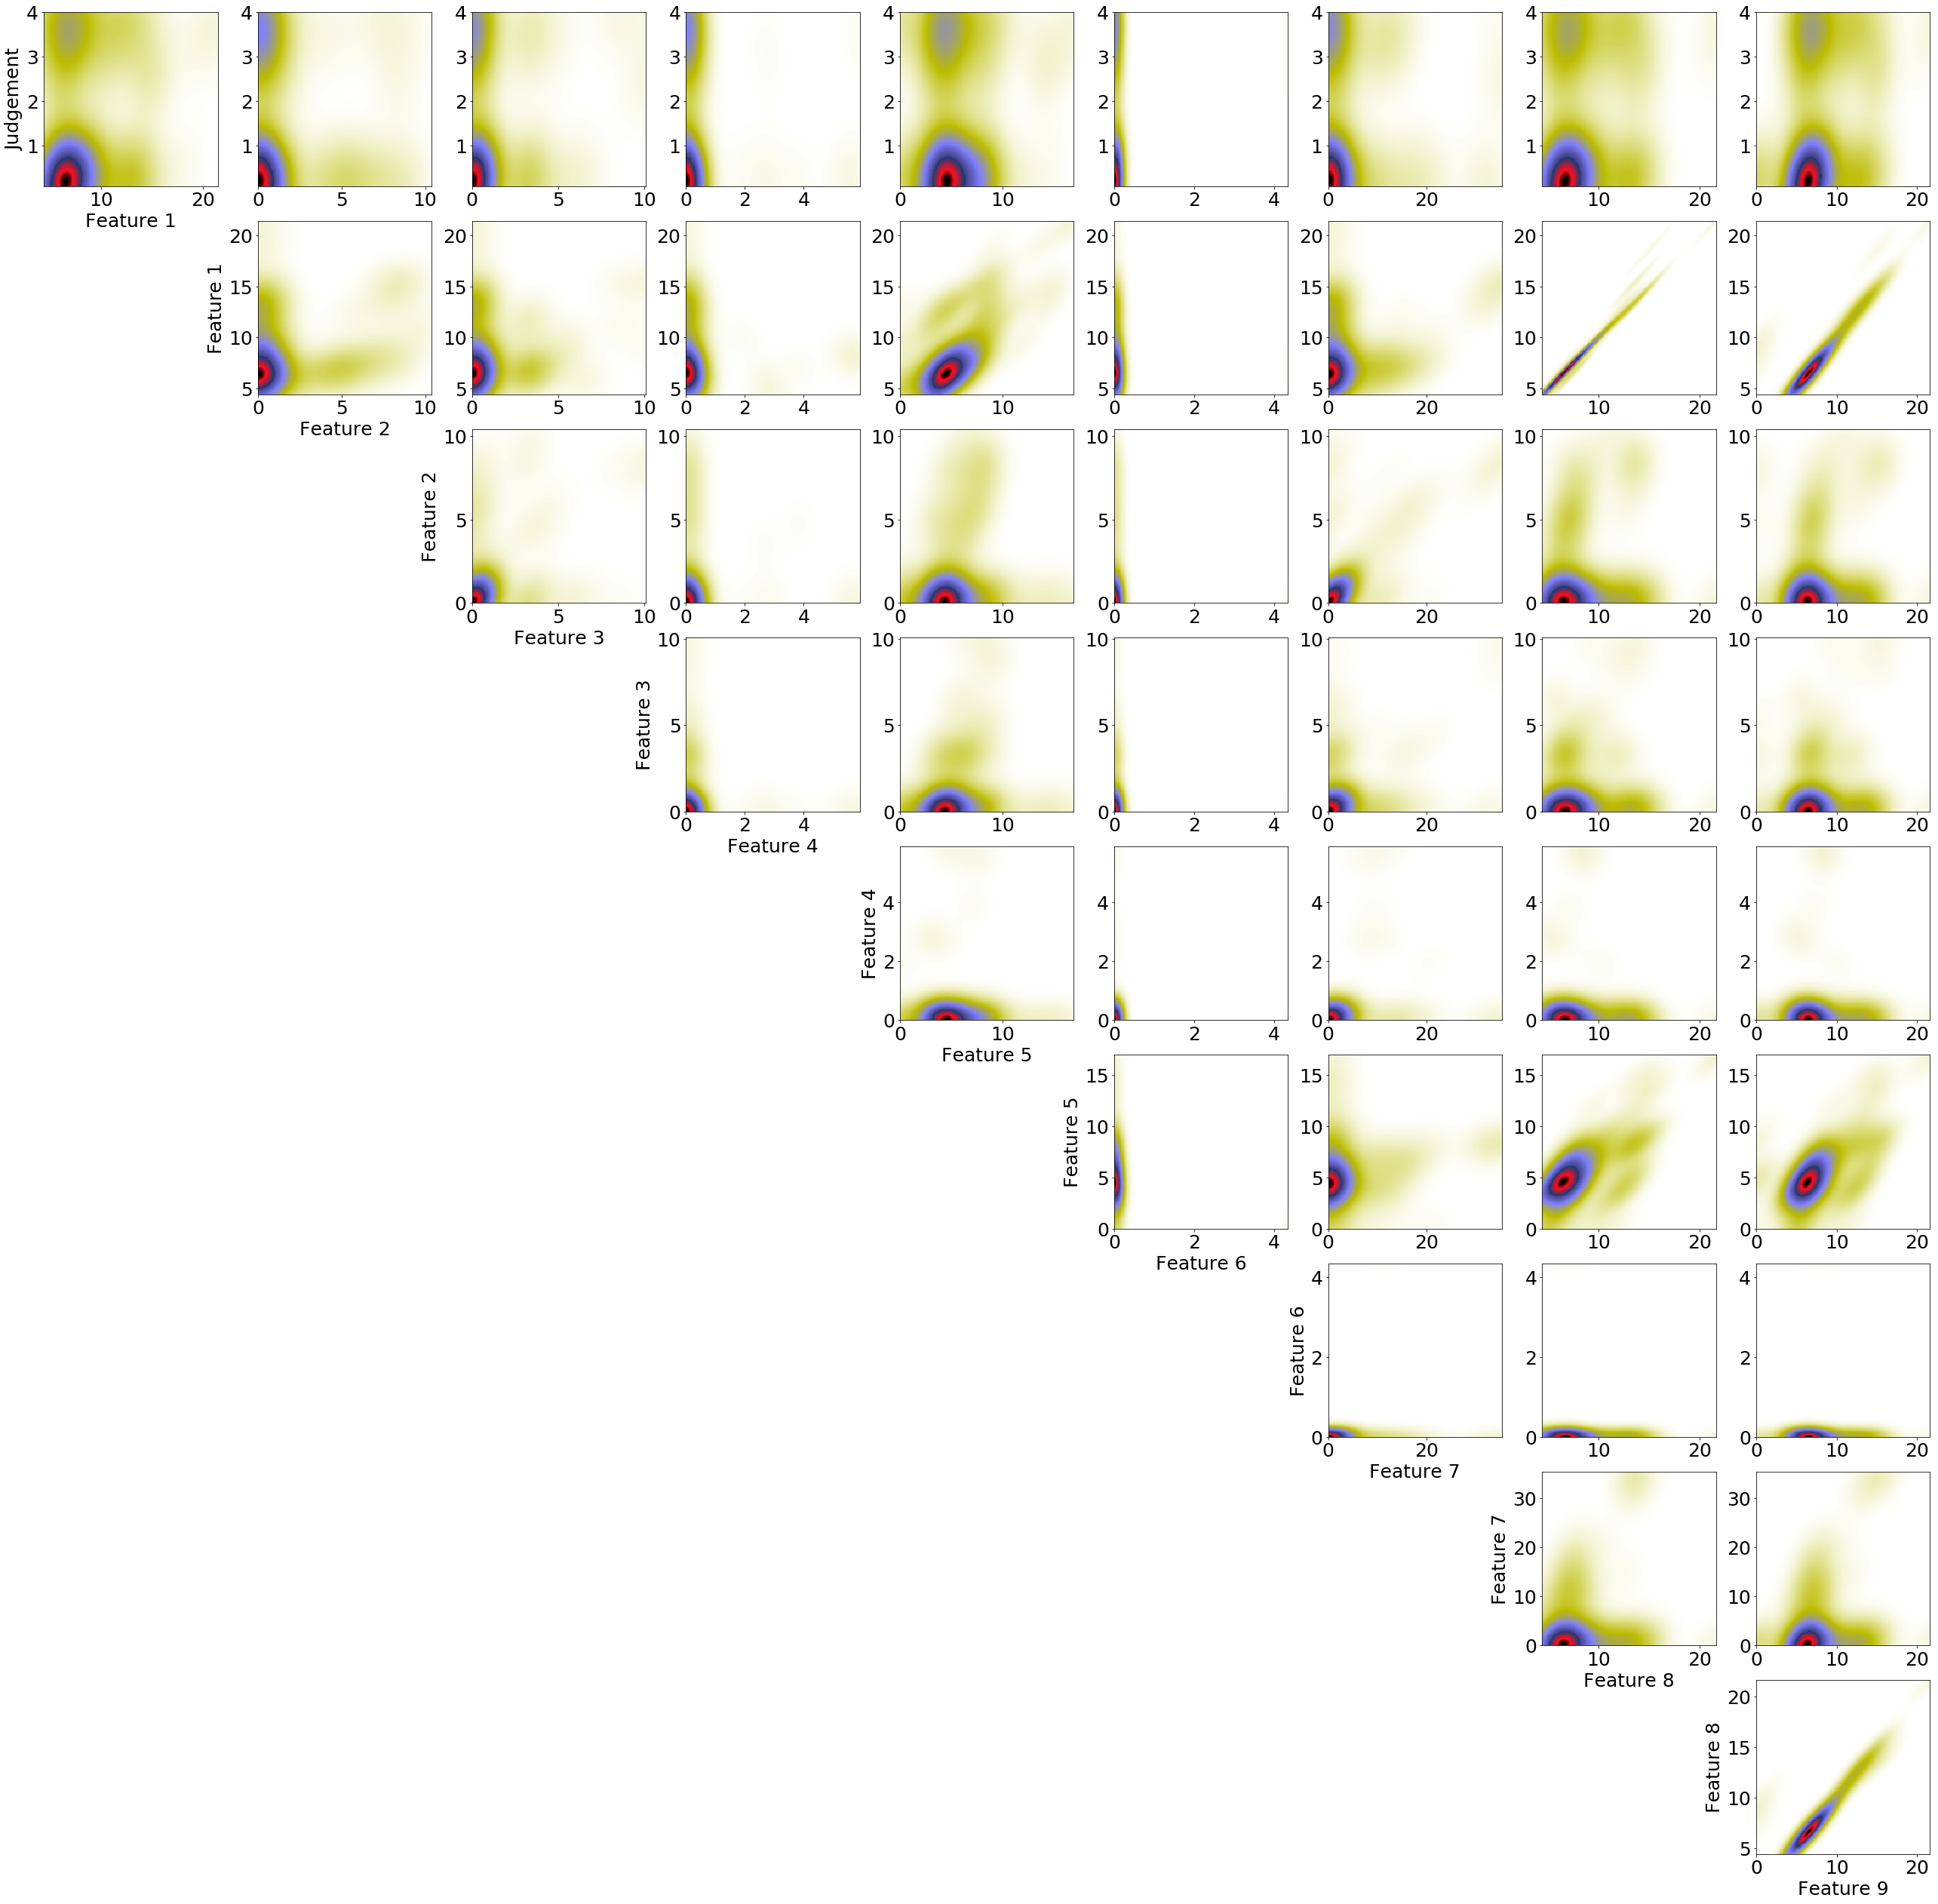

In [181]:
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
fs=25
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': fs,
         'axes.titlesize':fs,
         'xtick.labelsize':fs,
         'ytick.labelsize':fs}
pylab.rcParams.update(params)

def getValues(trainingData, i):
    if (i == 0):
        return "Judgement", trainingData["J"]
#     elif (i == 1 or i == 9):
#         return str(i), np.log10(trainingData[str(i)])
    else:
        return "Feature %d" % i, trainingData[str(i)]
    
def fitKernel(x,y,n=100j):
    xmin,xmax,ymin,ymax=(x.min(),x.max(),y.min(),y.max())

    X, Y = np.mgrid[xmin:xmax:n, ymin:ymax:n]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return np.rot90(Z), (xmin, xmax, ymin, ymax)

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

numFeatures = trainingData.numFeatures() + 1

fig = plt.figure(figsize=(50, 50))
gs = gridspec.GridSpec(numFeatures, numFeatures)

for i in range(numFeatures):
    rowLabel, rowValues = getValues(trainingData, i)
    labelRow = True
    for j in range(i+1, numFeatures):
        colLabel, colValues = getValues(trainingData, j)
        
        ax = plt.subplot(gs[i,j-numFeatures])

#         ax.text(0.25, 0.5, "ax %d:%d" % (i,j))
        if (labelRow):
            ax.set_ylabel(rowLabel)
            labelRow = False
        if (j == (i+1)):
            ax.set_xlabel(colLabel)
        
        try:
            Z, (xmin,xmax,ymin,ymax) = fitKernel(colValues, rowValues, 200j)
            extent = [xmin,xmax,ymin,ymax]
            ax.imshow(Z, cmap=plt.cm.gist_stern_r, extent=extent)
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            forceAspect(ax)
        except:
            pass
        

# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
#           extent=[xmin, xmax, ymin, ymax], aspect=50)
# ax.plot(x, y, 'k.', markersize=2)
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
plt.show()